In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cm
from scipy.stats import spearmanr

In [11]:
from sim_utils import get_corr_sim, generate_invariant_data, model_corr_noise
from plot_utils import plot_ground_truth_heatmap, plot_col_color_heatmap
from main_methods import run_procedure
from sim_utils import selction_eval
from spline_utils import setup_basis, spline_fit
from plot_utils import plot_scatter_discrete
from collections import Counter
from io_utils import save_data_to_file
from main_methods import compute_all_embeddings

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.DEBUG)

mddir = '/Users/jjzhu/Google Drive/_GLISS/data/scrna_sim'

def plot_embeddings(embed_dict, var_df):
    fontsize = 12
    sel_list = ["all", "rejected"]
    mat_list = ["coeffient", "expression"]
    fig, axes = plt.subplots(len(sel_list), len(mat_list), figsize=(3*len(mat_list), 2.5*len(sel_list)))
    for i, sel in enumerate(sel_list):
        for j, mat in enumerate(mat_list):
            plt_df = embed_dict["{}_{}".format(sel, mat)]
            ax = axes[j, i]
            var_labs = var_df.loc[plt_df["id"]]['nn_grp'].values
            print("{}".format(Counter(var_labs)))
            plot_scatter_discrete(plt_df[["umap 1", "umap 2"]].values, var_labs, ax=ax, ms=1)
            ax.set_xticks([]) 
            ax.set_yticks([]) 
            ax.set_xlabel("UMAP 1", fontsize=fontsize)
            if j == 0:
                ax.set_title("using {} genes\n".format(sel), fontsize=fontsize)
            if i == 0:
                ax.set_ylabel("using {} \nmatrix input\n\nUMAP 2".format(mat), fontsize=fontsize)
            else:
                ax.set_ylabel("UMAP 2".format(mat), fontsize=fontsize)
    # plt.savefig("/scratch/users/jjzhu/tmp_fig/spline_genes.pdf")
    plt.show()


def run_pipeline(regime):
    sim_params = get_corr_sim(mddir, regime=regime)
    
    ddir = sim_params['sim_dir']
    os.makedirs(ddir, exist_ok=True)
    fns = {
        'data_dict': os.path.join(ddir, 'data_dict.pkl'),
        'var_df': os.path.join(ddir, 'var_df.csv'),
        'result': os.path.join(ddir, 'method_result.pkl'),
        'coeff_mtx': os.path.join(ddir, 'coeff_matrix.npy'),
        'embed_dict': os.path.join(ddir, 'embed_dict.pkl'),
    }
    
    lam_true, z_init, x_init, var_df = generate_invariant_data(sim_params)
    z, x, v_df = model_corr_noise(sim_params['null_struct'], z_init, x_init)
    var_df = pd.concat([var_df, v_df], axis=1)
    data_dict = {'z': z, 'x': x, 'lam': lam_true}
    save_data_to_file(data_dict, fns['data_dict'], 'pkl')
    save_data_to_file(var_df, fns['var_df'], 'csv')

    result = run_procedure(z, x, sim_params['method_params'], fn=fns['result'])
    selction_eval(result, lam_true, sim_params, var_df)
    
    # get the variable group ids
    lam = result["lam_update"]
    base_args = setup_basis(lam)
    print(base_args)
    p_fun, c_mtx = spline_fit(lam, x, base_args)
    save_data_to_file(c_mtx, fns['coeff_mtx'], 'npy')

    embed_dict = compute_all_embeddings(result, c_mtx, x)
    save_data_to_file(embed_dict, fns['embed_dict'], 'pkl')
    plot_embeddings(embed_dict, var_df)


[feat_viz DEBUG] Data (length 3) saved as: /share/PI/sabatti/feat_viz/corr_sim/regime_0/data_dict.pkl
[feat_viz DEBUG] Data (shape (5994, 4)) saved as: /share/PI/sabatti/feat_viz/corr_sim/regime_0/var_df.csv
[feat_viz INFO] Running graph-based procedure
[feat_viz DEBUG] eig gap 0-> 1*: (0.0000, 0.4007*)
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting graph-based features...
[feat_viz INFO] Updated latent variables...
[feat_viz DEBUG] eig gap 0-> 1*: (0.0000, 0.0433*)
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/corr_sim/regime_0/method_result.pkl


{'FDP': 0.026200873362445413, 'Power': 0.5331739390316796, 'Corr': 0.9984615175384524, 'Num_Nonnulls': 1673, 'Num_Rejections': 916}
cr(x, knots=(-0.013, 0.012))
Fitted 1000 parameters
Fitted 2000 parameters
Fitted 3000 parameters
Fitted 4000 parameters
Fitted 5000 parameters


[feat_viz DEBUG] Data (shape (5994, 5)) saved as: /share/PI/sabatti/feat_viz/corr_sim/regime_0/coeff_matrix.npy


Computing embedding for: all_coeffient
input dimension: (5994, 5)


/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


Computing embedding for: all_expression
input dimension: (5994, 1500)
Computing embedding for: rejected_coeffient
input dimension: (916, 5)


/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


Computing embedding for: rejected_expression
input dimension: (916, 1500)


[feat_viz DEBUG] Data (length 4) saved as: /share/PI/sabatti/feat_viz/corr_sim/regime_0/embed_dict.pkl
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe08278e0f0>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] Setting pcolormesh
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe08278e0f0>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe08279e550>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] Setting pcolormesh
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe08279e550>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe082ac5a20>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] 

Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})
Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})
Counter({0: 150, 1: 150, 2: 150, 3: 150, 4: 145, 5: 144, -1: 27})
Counter({0: 150, 1: 150, 2: 150, 3: 150, 4: 145, 5: 144, -1: 27})


[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.a

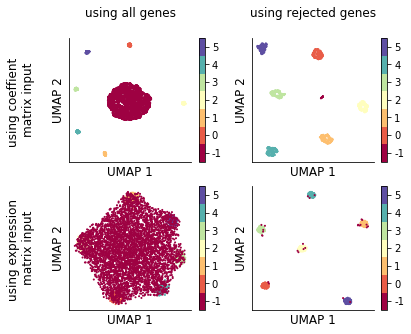

In [15]:
run_pipeline(0)

[feat_viz DEBUG] Data (length 3) saved as: /share/PI/sabatti/feat_viz/corr_sim/regime_1/data_dict.pkl
[feat_viz DEBUG] Data (shape (5994, 4)) saved as: /share/PI/sabatti/feat_viz/corr_sim/regime_1/var_df.csv
[feat_viz INFO] Running graph-based procedure
[feat_viz DEBUG] eig gap 0-> 1*: (0.0000, 0.3747*)
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting graph-based features...
[feat_viz INFO] Updated latent variables...
[feat_viz DEBUG] eig gap 0-> 1*: (-0.0000, 0.0644*)
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/corr_sim/regime_1/method_result.pkl


{'FDP': 0.024074074074074074, 'Power': 0.630005977286312, 'Corr': 0.9976637678505634, 'Num_Nonnulls': 1673, 'Num_Rejections': 1080}
cr(x, knots=(-0.011, 0.014))
Fitted 1000 parameters
Fitted 2000 parameters
Fitted 3000 parameters
Fitted 4000 parameters
Fitted 5000 parameters


[feat_viz DEBUG] Data (shape (5994, 5)) saved as: /share/PI/sabatti/feat_viz/corr_sim/regime_1/coeff_matrix.npy


Computing embedding for: all_coeffient
input dimension: (5994, 5)


/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


Computing embedding for: all_expression
input dimension: (5994, 1500)


/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 15 separate connected components using meta-embedding (experimental)
  n_components


Computing embedding for: rejected_coeffient
input dimension: (1080, 5)


/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


Computing embedding for: rejected_expression
input dimension: (1080, 1500)


[feat_viz DEBUG] Data (length 4) saved as: /share/PI/sabatti/feat_viz/corr_sim/regime_1/embed_dict.pkl
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe0806cf978>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] Setting pcolormesh
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe0806cf978>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe080688f28>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] Setting pcolormesh
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe080688f28>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe082c193c8>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] 

Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})
Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})
Counter({-1: 209, 0: 150, 1: 150, 2: 150, 3: 150, 5: 139, 4: 132})
Counter({-1: 209, 0: 150, 1: 150, 2: 150, 3: 150, 5: 139, 4: 132})


[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.a

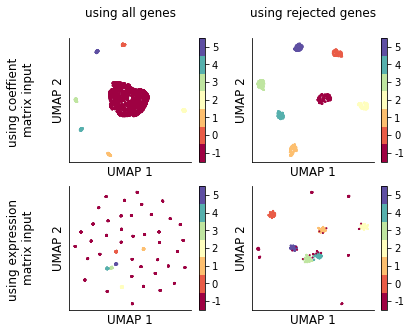

In [13]:
run_pipeline(1)

[feat_viz DEBUG] Data (length 3) saved as: /share/PI/sabatti/feat_viz/corr_sim/regime_2/data_dict.pkl
[feat_viz DEBUG] Data (shape (5994, 4)) saved as: /share/PI/sabatti/feat_viz/corr_sim/regime_2/var_df.csv
[feat_viz INFO] Running graph-based procedure
[feat_viz DEBUG] eig gap 0-> 1*: (0.0000, 0.3810*)
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting graph-based features...
[feat_viz INFO] Updated latent variables...
[feat_viz DEBUG] eig gap 0-> 1*: (-0.0000, 0.1432*)
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/corr_sim/regime_2/method_result.pkl


{'FDP': 0.025279247501469725, 'Power': 0.9910340705319785, 'Corr': 0.9950108920048409, 'Num_Nonnulls': 1673, 'Num_Rejections': 1701}
cr(x, knots=(-0.012, 0.013))
Fitted 1000 parameters
Fitted 2000 parameters
Fitted 3000 parameters
Fitted 4000 parameters
Fitted 5000 parameters


[feat_viz DEBUG] Data (shape (5994, 5)) saved as: /share/PI/sabatti/feat_viz/corr_sim/regime_2/coeff_matrix.npy


Computing embedding for: all_coeffient
input dimension: (5994, 5)


/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


Computing embedding for: all_expression
input dimension: (5994, 1500)
Computing embedding for: rejected_coeffient
input dimension: (1701, 5)


/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


Computing embedding for: rejected_expression
input dimension: (1701, 1500)


[feat_viz DEBUG] Data (length 4) saved as: /share/PI/sabatti/feat_viz/corr_sim/regime_2/embed_dict.pkl
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe08403ef98>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] Setting pcolormesh
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe08403ef98>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe0839bd438>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] Setting pcolormesh
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe0839bd438>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] locator: <matplotlib.ticker.FixedLocator object at 0x7fe08406c9e8>
[matplotlib.colorbar DEBUG] Using fixed locator on colorbar
[matplotlib.colorbar DEBUG] 

Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})
Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})
Counter({-1: 810, 0: 150, 1: 150, 2: 150, 3: 150, 5: 147, 4: 144})
Counter({-1: 810, 0: 150, 1: 150, 2: 150, 3: 150, 5: 147, 4: 144})


[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.axes._base DEBUG] update_title_pos
[matplotlib.a

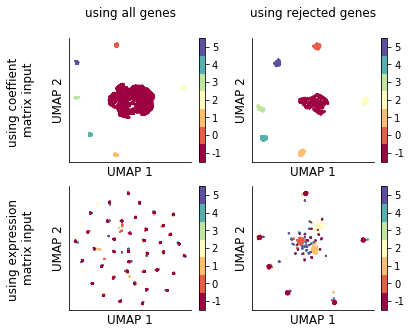

In [14]:
run_pipeline(2)